In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

figsize = (10,6)
pktPayloadSize = 1460 # Bytes

In [2]:
def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

In [3]:
workloadName = '_W5'
networkLoad = 0.5
simName = workloadName + '_load-' + str(int(networkLoad*100)) + 'p'
numSim = 3

In [4]:
msgStartEntryDict = {}
msgCompletionTimesDict = {}

for i in range(numSim):
    with open("MsgTraces"+simName+"_"+str(i)+".tr",'r') as f:
        for line in f:
            msgLog = line.split()

            time = float(msgLog[1])*1e-9        # in seconds
            msgSize = int(msgLog[2])#//1462*1462 # in bytes
            sender = msgLog[3]                  # ip:port
            receiver = msgLog[4]                # ip:port
            txMsgId = int(msgLog[5])

            key = (sender, receiver, txMsgId, i)

            if (msgLog[0]=='+'):
                if (key in msgStartEntryDict):
                    msgStartEntryDict[key].append(time)
                else:
                    msgStartEntryDict[key] = [time]

            elif (msgLog[0] =='-'):
                if (key in msgStartEntryDict):
                    startTime = msgStartEntryDict[key].pop()
                    if (len(msgStartEntryDict[key]) <= 0):
                        msgStartEntryDict = removekey(msgStartEntryDict, key)

                    if (msgSize in msgCompletionTimesDict):
                        msgCompletionTimesDict[msgSize].append(time-startTime)
                    else:
                        msgCompletionTimesDict[msgSize] = [time-startTime]
                else:
                    print('ERROR: Start entry of message (' \
                          + sender + ' > ' + receiver + ', ' + str(txMsgId) \
                          + ') not found!')

In [5]:
i = 0
for msgKey, msgStartTimes in msgStartEntryDict.items():
    print(msgKey, ' : ', msgStartTimes)
    i += len(msgStartTimes)
print ('Number of uncompleted messages: ' + str(i))

('10.0.48.1:1048', '10.0.30.1:1030', 1, 0)  :  [3.000660099]
Number of uncompleted messages: 1


In [6]:
print (json.dumps(msgCompletionTimesDict, sort_keys=True, indent=4))

{
    "1460": [
        4.001999999836414e-06
    ],
    "2920": [
        5.727000000010918e-06
    ],
    "5840": [
        8.187999999798024e-06,
        6.504999999989991e-06
    ],
    "7300": [
        8.805999999861314e-06,
        9.06799999977892e-06,
        8.806000000305403e-06
    ],
    "11680": [
        1.2066999999671424e-05,
        1.240899999999101e-05
    ],
    "13140": [
        1.3907000000035197e-05
    ],
    "14600": [
        1.4810999999781416e-05,
        1.51079999999304e-05,
        1.4811000000225505e-05,
        1.4811000000225505e-05
    ],
    "21900": [
        2.0816000000145607e-05,
        2.0815999999701518e-05
    ],
    "23360": [
        2.201700000004081e-05
    ],
    "24820": [
        2.3217999999936012e-05,
        2.3217999999936012e-05,
        2.3217999999936012e-05
    ],
    "26280": [
        2.4419000000275304e-05
    ],
    "27740": [
        2.5620000000170506e-05
    ],
    "30660": [
        2.8375999999941115e-05
    ],
    "

In [7]:
print('Number of distinct message sizes: ' + str(len(msgCompletionTimesDict)))

cntMultMeasures = 0
numMsgs = 0
nonFullPacketMsgSizes = []
for msgSize, msgCompletionTimes in msgCompletionTimesDict.items():
    
    if (len(msgCompletionTimes)>1):
        cntMultMeasures += 1
    
    numMsgs += len(msgCompletionTimes)
    
    if (msgSize%pktPayloadSize != 0):
        nonFullPacketMsgSizes.append((msgSize,msgSize%pktPayloadSize))
    
print('Number of distinct message sizes that '\
      +'have multiple measurements: ' + str(cntMultMeasures))   
print('Number of distinct messages: ' + str(numMsgs)) 

if (nonFullPacketMsgSizes):
    print('Non-Full Packet Message Sizes: ', nonFullPacketMsgSizes)

Number of distinct message sizes: 68
Number of distinct message sizes that have multiple measurements: 20
Number of distinct messages: 92


In [8]:
msgSizes = []
p50CompletionTimes = []
p99CompletionTimes = []
baseCompletionTimes = []
p50SlowDowns = []
p99SlowDowns = []

for msgSize, msgCompletionTimes in msgCompletionTimesDict.items():
    
    msgSizes.append(msgSize)
    
    times = np.array(msgCompletionTimes)
    p50CompletionTime = np.percentile(times,50)
    p50CompletionTimes.append(p50CompletionTime)
    p99CompletionTime = np.percentile(times,99)
    p99CompletionTimes.append(p99CompletionTime)
    
    baseCompletionTime = (msgSize+pktPayloadSize)*8.0/10e9 + 0.5e-6
    baseCompletionTimes.append(baseCompletionTime)
    
    p50SlowDowns.append(p50CompletionTime / baseCompletionTime)
    p99SlowDowns.append(p99CompletionTime / baseCompletionTime)
    
zipData = sorted(zip(msgSizes,
                     p50CompletionTimes,
                     p99CompletionTimes,
                     baseCompletionTimes,
                     p50SlowDowns,
                     p99SlowDowns))
    
msgSizes = np.array([x for x,_,_,_,_,_ in zipData])
p50CompletionTimes = np.array([x for _,x,_,_,_,_ in zipData])
p99CompletionTimes = np.array([x for _,_,x,_,_,_ in zipData])
baseCompletionTimes = np.array([x for _,_,_,x,_,_ in zipData])
p50SlowDowns = np.array([x for _,_,_,_,x,_ in zipData])
p99SlowDowns = np.array([x for _,_,_,_,_,x in zipData])

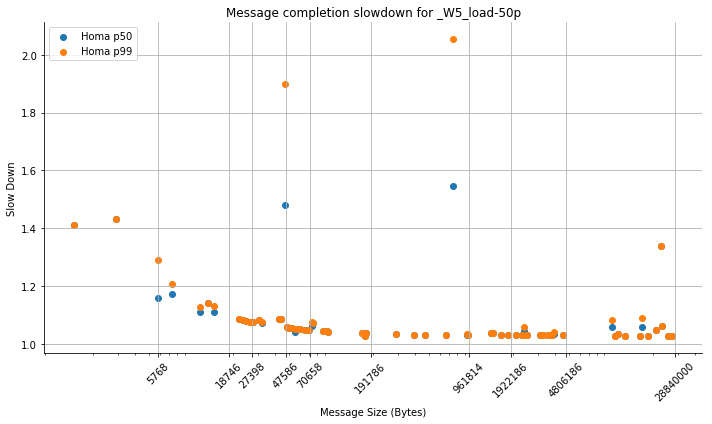

In [9]:
plt.figure(figsize=figsize)
plt.grid()

plt.scatter(msgSizes,p50SlowDowns,label='Homa p50')
plt.scatter(msgSizes,p99SlowDowns,label='Homa p99')

plt.ylabel('Slow Down')
plt.xlabel('Message Size (Bytes)')
plt.title('Message completion slowdown for '+simName)
plt.legend(loc='upper left')

# plt.ylim([1,15])
# plt.yscale('log')
# yticks = [1,2,3,4,15]
# plt.yticks(yticks, yticks)
plt.xscale('log')
xticks = [5768,18746,27398,47586,70658,191786,961814,1922186,4806186,28840000]
plt.xticks(xticks, xticks, rotation=45)

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.tight_layout()

# plt.savefig('MsgComletionSlowdown'+simName+'.png')
plt.show()